In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
colors = ["#EC7063","#AF7AC5","#7FB3D5","#1E8449"]

## Naïve Bayes Classifier from scratch

In [2]:
# Build Naïve Bayes Classifier
class NaiveBayesClassifier():
    '''
    Bayes Theorem form
    P(y|X) = P(X|y) * P(y) / P(X)
    where P(y) is the Prior, P(X|y) is the Likelihood, P(X) is Normalizing Constant given by
    P(X) = Σ P(X|y)*P(y) and P(y|X) is the Posterior that we need to calculate
    '''
    def calc_prior(self, features, target):
        '''
        calculate prior probabilities P(y)
        '''
        self.prior = (features.groupby(target).apply(lambda x:len(x))/self.rows).to_numpy()
        
        return self.prior
    
    def calc_statistics(self, features, target):
        '''
        calculate mean, variance for each column and convert to numpy array
        '''
        self.mean = features.groupby(target).apply(np.mean).to_numpy()
        self.var = features.groupby(target).apply(np.var).to_numpy()
        
        return self.mean, self.var
    
    def gaussian_density(self, class_idx, x):
        '''
        calculate probability from gaussian density function (normally distributed)
        assume that probability of specific target value given specific class is normally distributed
        
        formula:
        (1/√2pi*σ) * exp((-1/2)*((x-μ)^2)/(2*σ²)), where μ is mean, σ² is variance, σ is quare root of variance (standard deviation)
        '''
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        numerator = np.exp((-1/2)*((x-mean)**2)/(2*var))
        denominator = np.sqrt(2 * np.pi * var)
        prob = numerator / denominator
        return prob
    
    def calc_posterior(self, x):
        posteriors = []
        
        # calculate posterior probability for each class
        for i in range(self.count):
            # use log to make it numerically stable 
            prior = np.log(self.prior[i])
            conditional = np.sum(np.log(self.gaussian_density(i, x)))
            posterior = prior + conditional
            posteriors.append(posterior)
        # return class  =with highest posterior probalibity
        return self.classes[np.argmax(posteriors)]
    
    def fit(self, features, target):
        self.classes = np.unique(target)
        self.count = len(self.classes)
        self.feature_nums = features.shape[1]
        self.rows = features.shape[0]
        self.calc_statistics(features, target)
        self.calc_prior(features, target)
        
    def predict(self, features):
        preds = [self.calc_posterior(f) for f in features.to_numpy()]
        return preds
    
    def accuracy(self, y_test, y_pred):
        accuracy = np.sum(y_test == y_pred) / len(y_test)
        return accuracy
    
    def visualize(self, y_true, y_pred, target):
        
        tr = pd.DataFrame(data=y_true, columns=[target])
        pr = pd.DataFrame(data=y_pred, columns=[target])
        
        fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize = (16,5))
        
        sns.countplot(x=target, data=tr, ax=ax[0], palette=colors, alpha=0.7, hue=target, dodge=False)
        sns.countplot(x=target, data=pr, ax=ax[1], palette=colors, alpha=0.7, hue=target, dodge=False)
        
        fig.suptitle('True v.s. Predicted Comarison', fontsize=12)
        
        ax[0].tick_params(labelsize=8)
        ax[1].tick_params(labelsize=8)
        ax[0].set_title("True values", fontsize=10)
        ax[1].set_title("Predicted values", fontsize=10)
        plt.show()

## Test on Iris dataset

In [3]:
iris_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
iris = pd.read_csv(iris_url, header=None)
header=['sepal.length','sepal.width','petal.length','petal.width','variety']
iris.columns=header
iris.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
# randomly shuffle iris dataset with sampling
iris = iris.sample(frac=1, random_state=7).reset_index(drop=True)
# DataFrame shape
print(f'iris DataFrame shape is',iris.shape)

# set features and target
X, y = iris.iloc[:,:-1], iris.iloc[:, -1]
# split data into train and test sets 80%-20%
X_train, X_test, y_train, y_test = X[:120], X[120:], y[:120], y[120:]

print(f'X_train shape is',X_train.shape)
print(f'X_test shape is',X_test.shape)
print(f'y_train shape is',y_train.shape)
print(f'y_test shape is',y_test.shape)

iris DataFrame shape is (150, 5)
X_train shape is (120, 4)
X_test shape is (30, 4)
y_train shape is (120,)
y_test shape is (30,)


In [5]:
# train the model
nb = NaiveBayesClassifier()
nb.fit(X_train, y_train)
pred = nb.predict(X_test)
print(f'accuracy of Naïve Bayes Classifier is:', nb.accuracy(y_test, pred))

accuracy of Naïve Bayes Classifier is: 0.9666666666666667


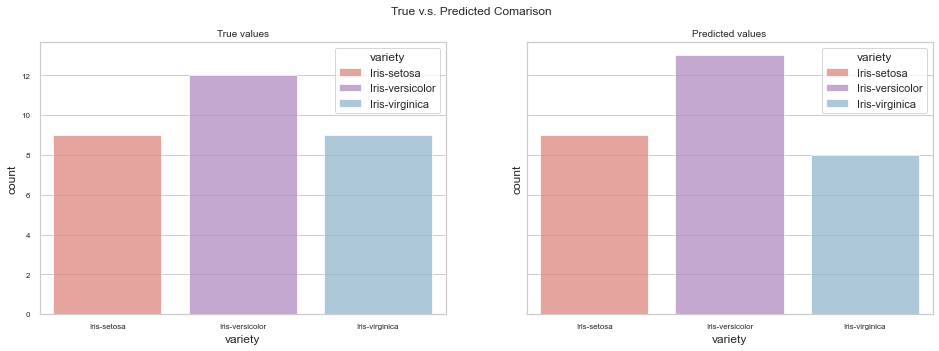

In [6]:
nb.visualize(y_test, pred, 'variety')

## Test on Spambase dataset

In [7]:
# Import Dataset
spam_url="https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
emails=pd.read_csv(spam_url, header=None)

# Import data column description
document_url="https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names"
document=pd.read_fwf(document_url, header=None).values.tolist()
lst=document[-57:]
header=[]

for i in range(57):
    f=' '.join(lst[i]).rstrip(': continuous.')
    header.append(f)

header.append('spam')
emails.columns=header

emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4601 non-null   float64
 1   word_freq_addre             4601 non-null   float64
 2   word_freq_all               4601 non-null   float64
 3   word_freq_3d                4601 non-null   float64
 4   word_freq_our               4601 non-null   float64
 5   word_freq_over              4601 non-null   float64
 6   word_freq_remove            4601 non-null   float64
 7   word_freq_interne           4601 non-null   float64
 8   word_freq_order             4601 non-null   float64
 9   word_freq_mail              4601 non-null   float64
 10  word_freq_receive           4601 non-null   float64
 11  word_freq_will              4601 non-null   float64
 12  word_freq_people            4601 non-null   float64
 13  word_freq_repor             4601 

In [8]:
#  Train Test Split
emails =  emails.sample(frac=1, random_state=7).reset_index(drop=True)

X=emails.drop('spam', axis=1)
y=emails['spam']

# split data into train and test sets 80%-20%
X_train, X_test, y_train, y_test = X[:3680], X[3680:], y[:3680], y[3680:]

print(f'X_train shape is',X_train.shape)
print(f'X_test shape is',X_test.shape)
print(f'y_train shape is',y_train.shape)
print(f'y_test shape is',y_test.shape)

X_train shape is (3680, 57)
X_test shape is (921, 57)
y_train shape is (3680,)
y_test shape is (921,)


In [9]:
nb.fit(X_train, y_train)
pred_spam = nb.predict(X_test)
print(f'accuracy of Naïve Bayes Classifier is:', nb.accuracy(y_test, pred_spam))

accuracy of Naïve Bayes Classifier is: 0.7861020629750272


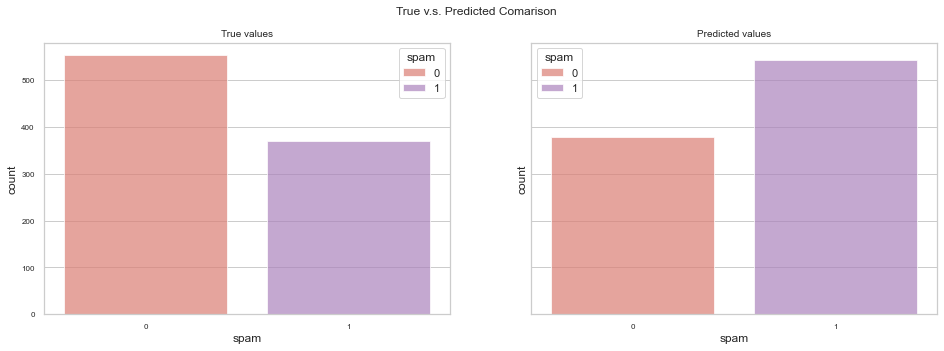

In [10]:
nb.visualize(y_test, pred_spam, 'spam')

Our Naïve Bayes Classifier performs poor in the spambase dataset.

### Compare to Naïve Bayes Classifier in Sklearn

In [11]:
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

# for Laplace smoothing strength alpha=1.0
print('BernoulliNB for precense with Laplace smoothing strength alpha=1.0', '\n')
bnb=BernoulliNB(alpha=1.0)
bnb.fit(X_train, y_train)
bnb_pred1=bnb.predict(X_test)
bnb_accuracy_score1=accuracy_score(y_test, bnb_pred1)
bnb_confusion_matrix1=confusion_matrix(y_test, bnb_pred1)
bnb_classification_report1=classification_report(y_test, bnb_pred1)
print(f'Accuracy for Laplace smoothing strength alpha=1.0: ', bnb_accuracy_score1)
print('\n')
print(f'Confusion matrix for Laplace smoothing strength alpha=1.0: ','\n', bnb_confusion_matrix1)
print('\n')
print(f'Classification report for Laplace smoothing strength alpha=1.0: ','\n', bnb_classification_report1)
print('===================================')

# for GaussianNB
print('GaussianNB for frequency counts', '\n')
gnb=GaussianNB()
gnb.fit(X_train, y_train)
gnb_pred=bnb.predict(X_test)
gnb_accuracy_score=accuracy_score(y_test, gnb_pred)
gnb_confusion_matrix=confusion_matrix(y_test, gnb_pred)
gnb_classification_report=classification_report(y_test, gnb_pred)
print(f'Accuracy for GaussianNB: ', gnb_accuracy_score)
print('\n')
print(f'Confusion matrix for GaussianNB with Laplace smoothing: ','\n', gnb_confusion_matrix)
print('\n')
print(f'Classification report for GaussianNB with Laplace smoothing: ','\n', gnb_classification_report)

BernoulliNB for precense with Laplace smoothing strength alpha=1.0 

Accuracy for Laplace smoothing strength alpha=1.0:  0.8816503800217155


Confusion matrix for Laplace smoothing strength alpha=1.0:  
 [[519  33]
 [ 76 293]]


Classification report for Laplace smoothing strength alpha=1.0:  
               precision    recall  f1-score   support

           0       0.87      0.94      0.90       552
           1       0.90      0.79      0.84       369

    accuracy                           0.88       921
   macro avg       0.89      0.87      0.87       921
weighted avg       0.88      0.88      0.88       921

GaussianNB for frequency counts 

Accuracy for GaussianNB:  0.8816503800217155


Confusion matrix for GaussianNB with Laplace smoothing:  
 [[519  33]
 [ 76 293]]


Classification report for GaussianNB with Laplace smoothing:  
               precision    recall  f1-score   support

           0       0.87      0.94      0.90       552
           1       0.90      0.79      